# CPSC 330 - Applied Machine Learning 

## Homework 4: Logistic regression, hyperparameter optimization 
### Associated lectures: [Lectures 7, 8](https://github.com/UBC-CS/cpsc330-2022W2) 

**Due date: Feb 10, 11:59pm**


## Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

## Instructions 
<hr>
rubric={points:6}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2022W2/blob/main/docs/homework_instructions.md). 

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- **Be kind** and respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

_Note: The assignments will get gradually more open-ended as we progress through the course. In many cases, there won't be a single correct solution. Sometimes you will have to make your own choices and your own decisions (for example, on what parameter values to use when they are not explicitly provided in the instructions). Use your own judgment in such cases and justify your choices, if necessary._

<br><br><br><br>

## Exercise 1: Implementing `DummyClassifier` 
<hr>
rubric={points:25}

In this course (unlike CPSC 340) you will generally **not** be asked to implement machine learning algorihtms (like logistic regression) from scratch. However, this exercise is an exception: you will implement the simplest possible classifier, `DummyClassifier`.

As a reminder, `DummyClassifier` is meant as a baseline and is generally the worst possible "model" you could "fit" to a dataset. All it does is predict the most popular class in the training set. So if there are more 0s than 1s it predicts 0 every time, and if there are more 1s than 0s it predicts 1 every time. For `predict_proba` it looks at the frequencies in the training set, so if you have 30% 0's 70% 1's it predicts `[0.3 0.7]` every time. Thus, `fit` only looks at `y` (not `X`).

Below you will find starter code for a class called `MyDummyClassifier`, which has methods `fit()`, `predict()`, `predict_proba()` and `score()`. Your task is to fill in those four functions. To get your started, I have given you a `return` statement in each case that returns the correct data type: 
- `fit` can return nothing, 
- `predict` returns an array whose size is the number of examples, 
- `predict_proba` returns an array whose size is the number of examples x 2, and 
- `score` returns a number.

The next code block has some tests you can use to assess whether your code is working. 

I suggest starting with `fit` and `predict`, and making sure those are working before moving on to `predict_proba`. For `predict_proba`, you should return the frequency of each class in the training data, which is the behaviour of `DummyClassifier(strategy='prior')`. Your `score` function should call your `predict` function. Again, you can compare with `DummyClassifier` using the code below.

To simplify this question, you can assume **binary classification**, and furthermore that these classes are **encoded as 0 and 1**. In other words, you can assume that `y` contains only 0s and 1s. The real `DummyClassifier` works when you have more than two classes, and also works if the target values are encoded differently, for example as "cat", "dog", "mouse", etc.

In [2]:

class MyDummyClassifier:
    """
    A baseline classifier that predicts the most common class.
    The predicted probabilities come from the relative frequencies
    of the classes in the training data.

    This implementation only works when y only contains 0s and 1s.
    """


    def fit(self, X, y):
        self.num_labels = len(y)
        self.one_count = np.count_nonzero(y)
        self.zero_count = self.num_labels - self.one_count
        self.one_percent = self.one_count / self.num_labels
        self.zero_percent = self.zero_count / self.num_labels
        self.highest_label = 0 if max(self.one_count, self.zero_count) == self.zero_count else 1
   
    def predict(self, X):
        return np.full(len(X), self.highest_label)

    def predict_proba(self, X):
        preds = []
        for i in range(len(X)):
            preds.append([self.zero_percent, self.one_percent])
        return preds
       

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

Below are some tests for `predict` using randomly generated data. You may want to run the cell a few times to make sure you explore the different cases (or automate this with a loop or random seeds).

In [3]:
# For testing, generate random data
n_train = 101
n_valid = 21
d = 5
X_train_dummy = np.random.randn(n_train, d)
X_valid_dummy = np.random.randn(n_valid, d)
y_train_dummy = np.random.randint(2, size=n_train)
y_valid_dummy = np.random.randint(2, size=n_valid)

my_dc = MyDummyClassifier()
sk_dc = DummyClassifier(strategy="prior")

my_dc.fit(X_train_dummy, y_train_dummy)
sk_dc.fit(X_train_dummy, y_train_dummy)

assert np.array_equal(my_dc.predict(X_train_dummy), sk_dc.predict(X_train_dummy))
assert np.array_equal(my_dc.predict(X_valid_dummy), sk_dc.predict(X_valid_dummy))

Below are some tests for `predict_proba`.

In [4]:
assert np.allclose(
    my_dc.predict_proba(X_train_dummy), sk_dc.predict_proba(X_train_dummy)
)
assert np.allclose(
    my_dc.predict_proba(X_valid_dummy), sk_dc.predict_proba(X_valid_dummy)
)

Below are some tests for `score`.

In [5]:
assert np.isclose(
    my_dc.score(X_train_dummy, y_train_dummy), sk_dc.score(X_train_dummy, y_train_dummy)
)
assert np.isclose(
    my_dc.score(X_valid_dummy, y_valid_dummy), sk_dc.score(X_valid_dummy, y_valid_dummy)
)

<br><br><br><br>

## Exercise 2: Trump Tweets
<hr>

For the rest of this assignment we'll be looking at a [dataset of Donald Trump's tweets](https://www.kaggle.com/austinreese/trump-tweets) as of June 2020. You should start by downloading the dataset. Unzip it and move the file `realdonaldtrump.csv` into this directory. As usual, please do not submit the dataset when you submit the assignment. 

In [6]:
tweets_df = pd.read_csv("realdonaldtrump.csv", index_col=0)
tweets_df.head()

,link,content,date,retweets,favorites,mentions,hashtags
id,,,,,,,
1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN
1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN
1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,NaN,NaN
1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,NaN,NaN


In [7]:
tweets_df.shape

(43352, 7)

We will be trying to predict whether a tweet will go "viral", defined as having more than 10,000 retweets:

In [8]:
y = tweets_df["retweets"] > 10_000

To make predictions, we'll be using only the content (text) of the tweet. 

In [9]:
X = tweets_df["content"]

For the purpose of this assignment, you can ignore all the other columns in the original dataset.

#### 2(a) ordering the steps
rubric={points:8}

Let's start by building a model using `CountVectorizer` and `LogisticRegression`. The code required to do this has been provided below, but in the wrong order. 

- Rearrange the lines of code to correctly fit the model and compute the cross-validation score. 
- Add a short comment to each block to describe what the code is doing.

In [10]:
# Splitting the data into training and testing splits. Assign this random splitting as state 111
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111)

# Declaring and instantiating the countvec model. 
# Ignore certain words as features with stop_words and set word list to built-in list using "english"
countvec = CountVectorizer(stop_words="english")

# Construct a logisticial regression model. Set its max iterations to 1000
lr = LogisticRegression(max_iter=1000) #changed this to use Ridge model instead of vanilla LinearRegression 

# Construct a pipeline object with the count vectorizer and logistical regression instances. 
pipe = make_pipeline(countvec, lr)

# Run Cross_validation with 5 folds. Return and store these results as a dataframe
cross_val_results = pd.DataFrame(
    cross_validate(pipe, X_train, y_train, return_train_score=True)
)

# Get the mean of the cross validation results.
cross_val_results.mean()



fit_time       1.979945
score_time     0.205980
test_score     0.898475
train_score    0.967952
dtype: float64

<br><br>

#### 2(b) Cross-validation fold sub-scores
rubric={points:3}

Above we averaged the scores from the 5 folds of cross-validation. 

- Print out the 5 individual scores. 
    - (Reminder: `sklearn` calls them `"test_score"` but they are really (cross-)validation scores.)
- Are the 5 scores close to each other or spread far apart? 
  - (This is a bit subjective, answer to the best of your ability.)
- How does the size of this dataset (number of rows) compare to the cities dataset we have been using in class? How does this relate to the different sub-scores from the 5 folds?

In [11]:
print(cross_val_results["test_score"])


0    0.895587
1    0.898047
2    0.896971
3    0.897893
4    0.903876
Name: test_score, dtype: float64


The 5 scores are relatively close to each other. The difference between the max and minimum "test_score"s is 0.83%. 

Only two features and one target column is given in the cities dataset. This is much less than the number of features created by CountVectorizer on the "content" column of the trump dataset. This means that there is less information in the cities dataset for a model like linear regression to create accurate predictions with, and so the cross validation scores of the model on the cities dataset is more subject random variance as seen as the wider range of cross validation scores. The trump dataset provides more features and more information for prediction generation and thus the accuracy of the model has less variance as there is less room for chance. 

#### 2(c) baseline
rubric={points:3}

By the way, are these scores any good? 

- Run `DummyClassifier` (or `MyDummyClassifier`!) on this dataset.
- Compare the `DummyClassifier` score to what you got from logistic regression above. Does logistic regression seem to be doing anything useful?
- Is it necessary to use `CountVectorizer` here? Briefly explain.

In [12]:
dummy_c = DummyClassifier(strategy="prior")

pipe1 = make_pipeline(countvec, dummy_c)

cross_val_results1 = pd.DataFrame(
    cross_validate(pipe1, X_train, y_train, return_train_score=True)
)

print(cross_val_results1["test_score"])

0    0.735353
1    0.735353
2    0.735353
3    0.735199
4    0.735312
Name: test_score, dtype: float64


In [13]:
dummy_c = DummyClassifier(strategy="prior")



cross_val_results2 = pd.DataFrame(
    cross_validate(dummy_c, X_train, y_train, return_train_score=True)
)

print(cross_val_results2["test_score"])

0    0.735353
1    0.735353
2    0.735353
3    0.735199
4    0.735312
Name: test_score, dtype: float64


Yes, it seems that using logistical regression results in a ~0.26 increase in test scores versus the DummyClassifier. 

No, it is not necessary to use CountVectorizer in this case as the DummyClassifier does not evaluate the features for patterns to determine its prediction. Instead it just returns the most common target value in the training set as its prediction. As seen above, not including count vectorization does not change the predictions of DummyClassifier on the dataset. 

#### 2(d) probability scores
rubric={points:5}

Here we train a logistic regression classifier on the entire training set: 

(Note: this is relying on the `pipe` variable from 2(a) - you'll need to redefine it if you overwrote that variable in between.)

In [14]:
pipe.fit(X_train, y_train);

In [15]:
#From Lecture 7 
soft_preds = pipe.predict_proba(X_test)

highest_pred = 0
highest_pred_index = 0

for index, pred in enumerate(soft_preds):
    highest_pred = max(pred[1], highest_pred)
    highest_pred_index = index
    
    
print(f"Highest Viral Probability Tweet: {X_test.iloc[highest_pred_index]}. Probability score: {highest_pred}.")

Highest Viral Probability Tweet: "@frankadgpr: @ realDonaldTrump @ ApprenticeNBC Clearly, you are a master of marketing and business success.". Probability score: 0.9999996932725573.


Using this model, find the tweet in the **test set** with the highest predicted probability of being viral. Print out the tweet and the associated probability score.

Reminder: you are free to reuse/adapt code from lecture. Please add in a small attribution, e.g. "From Lecture 7".

<br><br>

#### 2(e) coefficients
rubric={points:4}

We can extract the `CountVectorizer` and `LogisticRegression` objects from the `make_pipeline` object as follows:


In [16]:
vec_from_pipe = pipe.named_steps["countvectorizer"]
lr_from_pipe = pipe.named_steps["logisticregression"]

Using these extracted components above, display
- the 5 words with the highest coefficients and 
- the 5 words with the smallest coefficients.

In [17]:
print(vec_from_pipe)
print(lr_from_pipe)

CountVectorizer(stop_words='english')
LogisticRegression(max_iter=1000)


In [18]:
coefs = lr_from_pipe.coef_[0]
sorted_coef_indices = coefs.argsort()
top_5_coef_indices = sorted_coef_indices[-5:]
bottom_5_coef_indices = sorted_coef_indices[:5]

vocab = vec_from_pipe.vocabulary_
top_5_words = [list(vocab.keys())[list(vocab.values()).index(i)] for i in top_5_coef_indices]
bottom_5_words = [list(vocab.keys())[list(vocab.values()).index(i)] for i in bottom_5_coef_indices]

print(top_5_words)
print(bottom_5_words)

['fake', 'mini', 'coronavirus', 'harassment', 'obamagate']
['realdonaldtrump', 'trump2016pic', 'barackobama', 'donaldtrump', 'celebapprentice']


<br><br>

#### 2(f) Running a cross-validation fold without sklearn tools 
rubric={points:8}

Sklearn provides a lot of useful tools like `make_pipeline` and `cross_validate`, which are awesome. But with these fancy tools it's also easy to lose track of what is actually happening under the hood. 

**Your tasks:**

1. Compute logistic regression's validation score on the first fold, that is, train on 80% and validate on 20% of the training data (`X_train`) without using sklearn `Pipeline` or `cross_validate` or `cross_val_score`. Store the score of the fold in a variable called `fold_score`. Recall that `cross_validation` in `sklearn` does not shuffle the data by default.    

You should start with the following `CountVectorizer` and `LogisticRegression` objects, as well as `X_train` and `y_train` (which you should further split with `train_test_split` and `shuffle=False`):

In [19]:
countvec = CountVectorizer(stop_words="english")
lr = LogisticRegression(max_iter=1000)
X_train_encoded = countvec.fit_transform(X_train)

split_X_train, split_X_test = train_test_split(X_train_encoded, test_size=0.2, shuffle=False)
split_y_train, split_y_test = train_test_split(y_train, test_size=0.2, shuffle=False)

lr.fit(split_X_train, split_y_train)
y_pred = lr.predict(split_X_test)



In [20]:
from sklearn.metrics import accuracy_score
fold_score = accuracy_score(split_y_test, y_pred)

<br><br><br><br>

## Exercise 3: hyperparameter optimization
<hr>

#### 3(a)
rubric={points:4}

The following code varies the `max_features` hyperparameter of `CountVectorizer` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `max_features`. It also prints the results. 

Based on the plot/output, what value of `max_features` seems best? Briefly explain.

> **Note:** the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

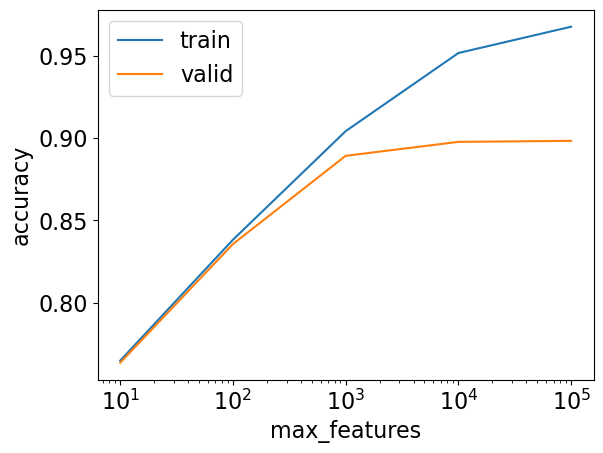

In [21]:
train_scores = []
cv_scores = []

max_features = [10, 100, 1000, 10_000, 100_000]

for mf in max_features:
    #     print(mf)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=mf),
        LogisticRegression(max_iter=1000),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)
    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(max_features, train_scores, label="train")
plt.semilogx(max_features, cv_scores, label="valid")
plt.legend()
plt.xlabel("max_features")
plt.ylabel("accuracy");

In [22]:
pd.DataFrame({"max_features": max_features, "train": train_scores, "cv": cv_scores})

,max_features,train,cv
0,10,0.764701,0.763425
1,100,0.838270,0.835671
2,1000,0.904380,0.889371
3,10000,0.951936,0.897860
4,100000,0.967952,0.898475


It seems that 10^3 max_features is the most optimal as it yields the highest validation score, without overfitting to the training data. 

<br><br>

#### 3(b)
rubric={points:6}

The following code varies the `C` hyperparameter of `LogisticRegression` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `C`. 

Based on the plot, what value of `C` seems best?

> **Note:** the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

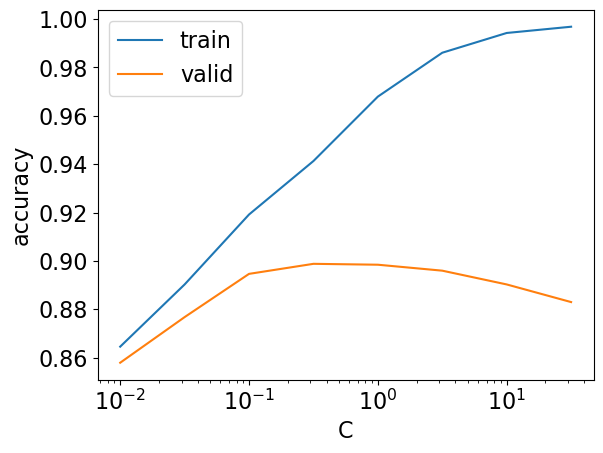

In [23]:
train_scores = []
cv_scores = []

C_vals = 10.0 ** np.arange(-2, 2, 0.5)

for C in C_vals:
    #     print(C)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=None),
        LogisticRegression(max_iter=1000, C=C),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)

    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(C_vals, train_scores, label="train")
plt.semilogx(C_vals, cv_scores, label="valid")
plt.legend()
plt.xlabel("C")
plt.ylabel("accuracy");

In [24]:
pd.DataFrame({"C": C_vals, "train": train_scores, "cv": cv_scores})

,C,train,cv
0,0.010000,0.864612,0.857969
1,0.031623,0.890316,0.876822
2,0.100000,0.919227,0.894692
3,0.316228,0.941333,0.898844
4,1.000000,0.967952,0.898475
5,3.162278,0.986091,0.896014
6,10.000000,0.994256,0.890324
7,31.622777,0.996840,0.883035


The value of C around ~0.316 seems to give the best validation score without overfitting to the training data. 

<br><br>

#### 3(c) Hyperparameter optimization 
rubric={points:10}

Start with the pipeline `pipe` below.

**Your tasks:**
- Create a `GridSearchCV` object named `grid_search` to jointly optimize `max_features` of `CountVectorizer` and `C` of `LogisticRegression` across all the combinations of values we tried above. 
- What are the best values of `max_features` and `C` according to your grid search? 
- Store them in variables `best_max_features` and `best_C`, respectively.  
- Store the best score returned by the grid search in a variable called `best_score`. 

> The code might be a bit slow here. Setting `n_jobs=-1` should speed it up if you have a multi-core processor.

In [46]:

param_grid = {
    'vect__max_features': [10, 100, 1000, 10_000, 100_000],
    'clf__C': 10.0 ** np.arange(-2, 2, 0.5)
}

pipe1 = Pipeline([('vect', CountVectorizer(stop_words="english")),
                 ('clf', LogisticRegression(max_iter=1000))])

grid_search = GridSearchCV(
    pipe1, param_grid, cv = 5, n_jobs = -1, return_train_score = True
)



In [47]:

grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [26]:
grid_search.best_params_
type(grid_search.best_params_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [27]:
best_score = grid_search.best_score_

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

<br><br>

#### 3(d) Discussion 
rubric={points:4}

- Do the best values of hyperparameters found by Grid Search agree with what you found in 3(a) and 3(b)? 
- **Generally speaking**, _should_ these values agree with what you found in parts  3.1 and 3.2? Why or why not? 

#### 3(e) Test score
rubric={points:2}

- Evaluate your final model on the test set. Store the test accuracy in the variable called `test_score`.

In [34]:
test_score = grid_search.score(X_test, y_test)

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

#### 3(f) Discussion of Test Score
rubric={points:4}

- How does your test accuracy compare to your validation accuracy? 
- If they are different: do you think this is because you "overfitted on the validation set", or simply random luck?

## Exercise 4: Very short answer questions
rubric={points:8}

Each question is worth 2 points. Max 2 sentences per answer.

1. What is the problem with calling `fit_transform` on your test data with `CountVectorizer`? 
2. If you could only access one of `predict` or `predict_proba`, which one would you choose? Briefly explain.
3. What are two advantages of `RandomizedSearchCV` over `GridSearchCV`?
4. Why is it important to follow the Golden Rule? If you violate it, will that give you a worse classifier?

1. First, calling fit on the test data violates the golden rule. We always want to fit our model on the training split only, as mixing the two would void the test data's purpose to be a test of real world predictions in which the model is given data that it has never seen before. 

2. Calling predict solely returns the classification label for each data point, while calling predict_proba returns the probability of a classification for each data point. In this regard, predict_proba seems to give more information as you can infer the classification label from the probability, while also evaluating the confidence of the model on each classification. Perhaps this ma

3.  By sampling randomly over the entire grid of parameters, the chance of the set of parameters being a representative sample that may contain the optimal parameter values. Without knowing the optimal parameter values, you cannot guarentee that these will be covered by GridSearchCV. Furthermore, RandomSearchCV is computationally less expensive than GridSearchCV and is a faster model.

4. The golden rule states that although we most care about optimizing the test error, we must NEVER mix test data into the training set. It is important to follow this rule as we want our validation step to be representative of real world scenarios where the model is given data to predict on that it has never seen before. Violating this would result in issues such as not being able to identify whether or not your classifier has over-fitted to the training data, as the validation data needed to identify this was already trained upon. 

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 